# **Food-101 Full Project 🍴**

In our last project, we built a model called Food Vision mini that could recognize food images 📸. But we only used a small part of the data 🤔. Now, we're going to use all the data to build a new model called Food-101 Full 🚀.

### **Our Goal 🏆**

We want to beat the results of a research paper called DeepFood, which achieved 77.4% accuracy in recognizing food images 🤯. We'll use a technique called transfer learning to build our model 💡.

### **What We'll Do 📝**

Here's what we'll cover in this project:

1. Get the data and prepare it for our model 📊
2. Create a model that can recognize food images 📸
3. Make our model faster and more accurate ⏱️
4. Test our model and see how well it works 📊

### **Key Concepts 🤔**

* **Top-1 accuracy**: How well our model can predict the correct food image 📊
* **Top-5 accuracy**: How well our model can predict the correct food image among its top 5 guesses 🤔
* **Mixed precision training**: A technique that makes our model train faster ⏱️
* **Prefetching**: A technique that makes our model load data faster 📈

### **Let's Get Started 🎉**

We'll go through each step of the project and explain what we're doing and why 🤔. By the end of this project, we'll have a model that can recognize food images with high accuracy 📊. So, let's dive in and start building our Food-101 Full model 🚀

In [71]:
import os

if not os.path.exists("helper.py"):
    !wget https://raw.githubusercontent.com/siddhant-rajhans/TensorFlow/refs/heads/main/Basics/helper/helper.py

else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

from helper import create_tensorboard_callback, plot_loss_curves, compare_historys

[INFO] 'helper_functions.py' already exists, skipping download.


In [72]:
import tensorflow_datasets as tfds

In [73]:
# Dataset list
dsl = tfds.list_builders()
print("food101" in dsl)

True


In [74]:
# Train, test, dataset info
(trd, ted), dsi = tfds.load(name="food101",
                             split=["train","validation"],
                             shuffle_files=True,
                              as_supervised=True,
                            with_info=True)

In [75]:
dsi

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo nu

In [76]:
dsi.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [77]:
dsi.features["label"].names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [78]:
class_names = dsi.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [79]:
sample1= ted.take(1)

In [80]:
sample1

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [81]:
# Output info about our training sample
for image, label in sample1:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (382, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 29
  Class name (str form): cup_cakes
  


In [82]:
image, class_names[label]

(<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
 array([[[ 34,  76, 100],
         [ 30,  72,  96],
         [ 29,  70,  92],
         ...,
         [ 81, 101, 108],
         [ 77,  97, 104],
         [ 69,  89,  96]],
 
        [[ 35,  77, 101],
         [ 32,  74,  98],
         [ 32,  73,  95],
         ...,
         [ 75,  95, 102],
         [ 72,  92,  99],
         [ 68,  88,  95]],
 
        [[ 36,  78, 102],
         [ 34,  76, 100],
         [ 35,  75, 100],
         ...,
         [ 68,  88,  97],
         [ 68,  88,  95],
         [ 67,  87,  94]],
 
        ...,
 
        [[ 25,  21,  18],
         [ 25,  21,  18],
         [ 25,  24,  20],
         ...,
         [137, 152, 155],
         [128, 143, 146],
         [122, 137, 140]],
 
        [[ 28,  25,  20],
         [ 28,  25,  20],
         [ 29,  26,  21],
         ...,
         [137, 150, 158],
         [135, 148, 156],
         [135, 148, 154]],
 
        [[ 29,  26,  21],
         [ 30,  27,  22],
         [ 30,

In [83]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

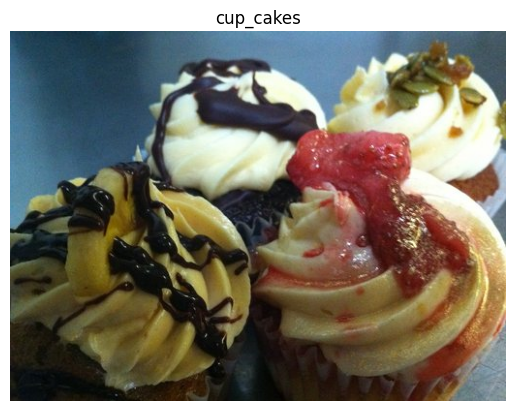

In [84]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()
]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data 📊

In previous notebooks, when our images were in folder format we used the method `tf.keras.utils.image_dataset_from_directory()` to load them in 📁.

Doing this meant our data was loaded into a format ready to be used with our models 📈.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model 🤔.

More specifically, our data is currently:

* In `uint8` data type 📊
* Comprised of all different sized tensors (different sized images) 📸
* Not scaled (the pixel values are between 0 & 255) 📊

Whereas, models like data to be:

* In `float32` data type 📊
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`) 📈
* Scaled (values between 0 & 1), also called normalized 📊

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()` 📸
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()` 📊

> **📽Important:** Pretrained EfficientNetBX models in `tf.keras.applications.efficientnet` (what we're going to be using) have rescaling built-in 🤔. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1) 📊. This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a `tf.keras.layers.Rescaling` layer 📈.

In [85]:
# preprocess_image
def pp(image, label, img_shape=224):
  image=tf.image.resize(image, [img_shape,img_shape])
  image = image/255.
  return tf.cast(image, tf.float32), label

In [86]:
# preprocessed image
ppi= pp(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]}..., \nShape: {image.shape},\nDtype: {image.dtype} ")

print(f"Image after preprocessing: \n {ppi[:2]}..., \nShape: {ppi.shape},\nDtype: {ppi.dtype} ")

Image before preprocessing: 
 [[[ 34  76 100]
  [ 30  72  96]
  [ 29  70  92]
  ...
  [ 81 101 108]
  [ 77  97 104]
  [ 69  89  96]]

 [[ 35  77 101]
  [ 32  74  98]
  [ 32  73  95]
  ...
  [ 75  95 102]
  [ 72  92  99]
  [ 68  88  95]]]..., 
Shape: (382, 512, 3),
Dtype: <dtype: 'uint8'> 
Image after preprocessing: 
 [[[0.12552147 0.29022735 0.384345  ]
  [0.12751475 0.28829908 0.3745736 ]
  [0.14287464 0.2829144  0.3762405 ]
  ...
  [0.28650323 0.3649346  0.40408263]
  [0.2973516  0.375783   0.40580243]
  [0.28581592 0.36424732 0.3916983 ]]

 [[0.13628076 0.30098665 0.3951856 ]
  [0.14478166 0.3016444  0.39968362]
  [0.135623   0.27511877 0.37053195]
  ...
  [0.29142138 0.36962518 0.4134452 ]
  [0.26643908 0.34487045 0.38058722]
  [0.26534727 0.34377864 0.37152222]]]..., 
Shape: (224, 224, 3),
Dtype: <dtype: 'float32'> 


In [88]:
ppi

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.12552147, 0.29022735, 0.384345  ],
        [0.12751475, 0.28829908, 0.3745736 ],
        [0.14287464, 0.2829144 , 0.3762405 ],
        ...,
        [0.28650323, 0.3649346 , 0.40408263],
        [0.2973516 , 0.375783  , 0.40580243],
        [0.28581592, 0.36424732, 0.3916983 ]],

       [[0.13628076, 0.30098665, 0.3951856 ],
        [0.14478166, 0.3016444 , 0.39968362],
        [0.135623  , 0.27511877, 0.37053195],
        ...,
        [0.29142138, 0.36962518, 0.4134452 ],
        [0.26643908, 0.34487045, 0.38058722],
        [0.26534727, 0.34377864, 0.37152222]],

       [[0.14164916, 0.30528584, 0.40593612],
        [0.1517332 , 0.30859593, 0.40962887],
        [0.13705607, 0.28018707, 0.3823467 ],
        ...,
        [0.27205864, 0.34656844, 0.40147042],
        [0.27194008, 0.35037145, 0.3929484 ],
        [0.27265406, 0.35108542, 0.38571674]],

       ...,

       [[0.07676984, 0.07006434, 0.06129323],
        [0.07

In [93]:
trd = trd.map(map_func=pp, num_parallel_calls=tf.data.AUTOTUNE)
trd = trd.shuffle(buffer_size=1000).batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)

ted = ted.map(pp, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)


In [94]:
trd, ted

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [96]:
from helper import create_tensorboard_callback

In [98]:
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_acc",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

In [99]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [101]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [103]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [113]:
from tensorflow.keras import layers

input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape,name="input_layer")
x= base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs= layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

model.compile(loss="sparse_catergorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [114]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [118]:
for layer in model.layers:
  print(layer.name,layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_1 True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [120]:
for layer in model.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_4 False float32 <DTypePolicy "mixed_float16">
rescaling_8 False float32 <DTypePolicy "mixed_float16">
normalization_4 False float32 <DTypePolicy "mixed_float16">
rescaling_9 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">


In [ ]:
hist= model.fit(trd,
                epochs=3,
                steps_per_epochs=len(trd),
                validation_data=ted,
                validation_steps=int(0.15*len(ted)),
                callbacks=[create_tensorboard_callback(dir_name="training_logs", experiment_name="efficientnet"),
                           model_checkpoint])